<a href="https://colab.research.google.com/github/Robinino99/Prediction-of-Product-Sales/blob/main/Project_1_Final_(Core).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Project 1 - Part 5

##Data Dictionary

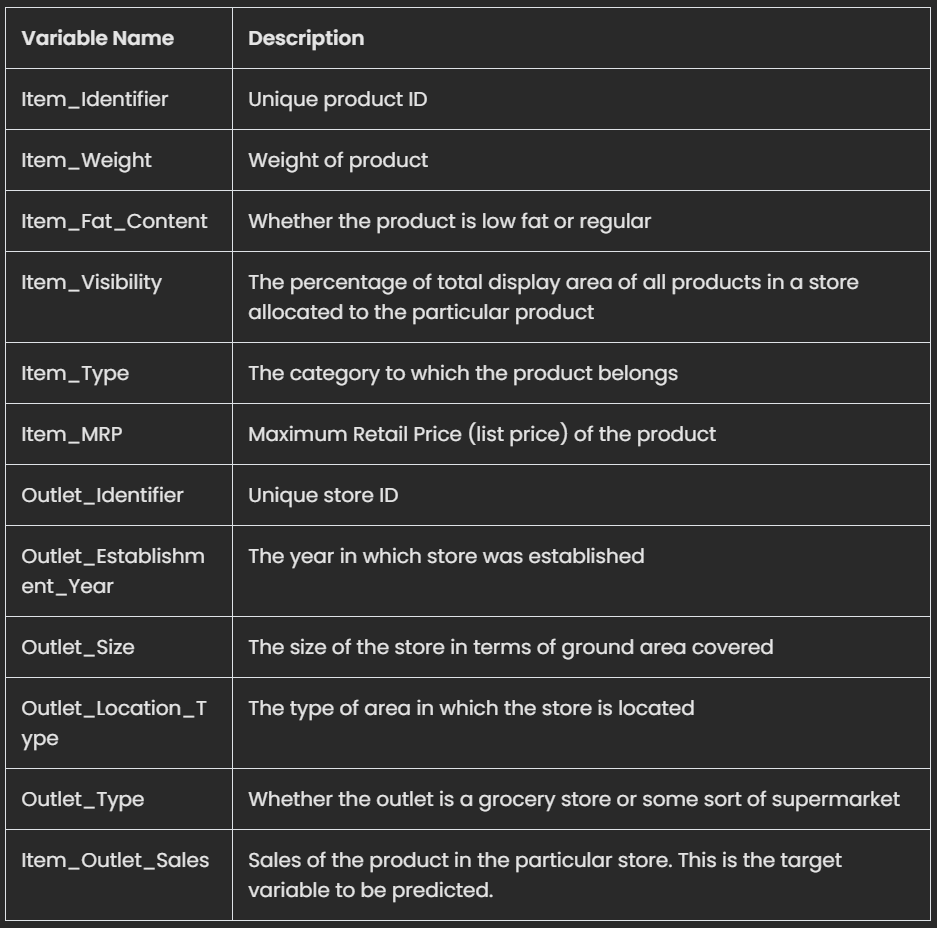

In [1]:
# mount google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# import necessary packages
import pandas as pd
pd.set_option('display.max_columns', 100)
import missingno

#sklearn
from sklearn.model_selection import train_test_split, GridSearchCV #
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression # Lin model
from sklearn.ensemble import RandomForestRegressor # RandomForest Model

# Set pandas as the default output for sklearn
from sklearn import set_config
set_config(transform_output = 'pandas')



In [3]:
# custom function
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
def regression_metrics(y_true, y_pred, label='', verbose = True, output_dict=False):
  # Get metrics
  mae = mean_absolute_error(y_true, y_pred)
  mse = mean_squared_error(y_true, y_pred)
  rmse = mean_squared_error(y_true, y_pred, squared=False)
  r_squared = r2_score(y_true, y_pred)
  if verbose == True:
    # Print Result with Label and Header
    header = "-"*60
    print(header, f"Regression Metrics: {label}", header, sep='\n')
    print(f"- MAE = {mae:,.3f}")
    print(f"- MSE = {mse:,.3f}")
    print(f"- RMSE = {rmse:,.3f}")
    print(f"- R^2 = {r_squared:,.3f}")
  if output_dict == True:
      metrics = {'Label':label, 'MAE':mae,
                 'MSE':mse, 'RMSE':rmse, 'R^2':r_squared}
      return metrics
def evaluate_regression(reg, X_train, y_train, X_test, y_test, verbose = True,
                        output_frame=False):
  # Get predictions for training data
  y_train_pred = reg.predict(X_train)
  # Call the helper function to obtain regression metrics for training data
  results_train = regression_metrics(y_train, y_train_pred, verbose = verbose,
                                     output_dict=output_frame,
                                     label='Training Data')
  print()
  # Get predictions for test data
  y_test_pred = reg.predict(X_test)
  # Call the helper function to obtain regression metrics for test data
  results_test = regression_metrics(y_test, y_test_pred, verbose = verbose,
                                  output_dict=output_frame,
                                    label='Test Data' )
  # Store results in a dataframe if ouput_frame is True
  if output_frame:
    results_df = pd.DataFrame([results_train,results_test])
    # Set the label as the index
    results_df = results_df.set_index('Label')
    # Set index.name to none to get a cleaner looking result
    results_df.index.name=None
    # Return the dataframe
    return results_df.round(3)

In [4]:
# create and load the data to the dataframe
fpath = '/content/drive/MyDrive/Coding Dojo/CodingDojo/02-MachineLearning/Week06/Data/sales_predictions_2023.csv'

# load the data into the dataframe
df = pd.read_csv(fpath)

# display the first 5 rows
df.head()


,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


In [5]:
# get the information about the dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                7060 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                6113 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB


As from the above we can see that there are missing values in the following two features (columns)
* Item_Weight
* Outlet_Size

Two features columns to remove:
* Item_Identifier - unique product id (primary key) no value to our model.
* Outlet_Identifier - unique outlet/store id (foreign key) no value to our model.
* Outlet_Establishment_Year = No value to our model.

In [6]:
# Remove the two columns as listed above
df = df.drop(columns = ['Item_Identifier', 'Outlet_Identifier', 'Outlet_Establishment_Year'])
df.head()

,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,9.30,Low Fat,0.016047,Dairy,249.8092,Medium,Tier 1,Supermarket Type1,3735.1380
1,5.92,Regular,0.019278,Soft Drinks,48.2692,Medium,Tier 3,Supermarket Type2,443.4228
2,17.50,Low Fat,0.016760,Meat,141.6180,Medium,Tier 1,Supermarket Type1,2097.2700
3,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,NaN,Tier 3,Grocery Store,732.3800
4,8.93,Low Fat,0.000000,Household,53.8614,High,Tier 3,Supermarket Type1,994.7052


In [7]:
# check for duplicates
df.duplicated().sum()

0

###Check for Data Inconsistencies


In [8]:
# test object columns for data values

# create a list of object columns
obj_cols = df.select_dtypes('object').columns

# loop through the columns and get value_counts
for col in obj_cols:
  print(f"For column {col}")
  print(df[col].value_counts())
  # ease legibility
  print("\n")

For column Item_Fat_Content
Low Fat    5089
Regular    2889
LF          316
reg         117
low fat     112
Name: Item_Fat_Content, dtype: int64


For column Item_Type
Fruits and Vegetables    1232
Snack Foods              1200
Household                 910
Frozen Foods              856
Dairy                     682
Canned                    649
Baking Goods              648
Health and Hygiene        520
Soft Drinks               445
Meat                      425
Breads                    251
Hard Drinks               214
Others                    169
Starchy Foods             148
Breakfast                 110
Seafood                    64
Name: Item_Type, dtype: int64


For column Outlet_Size
Medium    2793
Small     2388
High       932
Name: Outlet_Size, dtype: int64


For column Outlet_Location_Type
Tier 3    3350
Tier 2    2785
Tier 1    2388
Name: Outlet_Location_Type, dtype: int64


For column Outlet_Type
Supermarket Type1    5577
Grocery Store        1083
Supermarket Type3     9

As indicated above there are data inconsistencies present in the Item_Fat_Content feature.

In [9]:
# replace the values in the Item_Fat_Content feature to align and create consistency.
df['Item_Fat_Content'] = df['Item_Fat_Content'].replace({'LF': 'Low Fat',
                                                         'reg': 'Regular',
                                                         'low fat': 'Low Fat'})
# validate the changes have been made
df['Item_Fat_Content'].value_counts()

Low Fat    5517
Regular    3006
Name: Item_Fat_Content, dtype: int64

###Feature Review

* Numeric feature - Item_Weight
* Categorical Column - Outlet_Size

####Numeric

In [10]:
# Check the statistical values of the Item_Weight feature
df['Item_Weight'].describe()

count    7060.000000
mean       12.857645
std         4.643456
min         4.555000
25%         8.773750
50%        12.600000
75%        16.850000
max        21.350000
Name: Item_Weight, dtype: float64

Based on the above result our mean value of '12.857...' lies between our upper and lower quartiles. We shall apply the median strategy to account for any outliers.

####Catergorical

In [11]:
# Check the number of null (NaN) values in the [Outlet_Size]
df['Outlet_Size'].isna().sum()

2410

As indicated above - 2410 values are null. This is roughly 28.3% of our column values. We cannot apply the simpleimputer with the 'most frequent strategy'. We will have to default this null values to 'MISSING'.

####Train_Test_Split

The column in this exercise which we are trying to predict is the 'Item_Outlet_Sales'. (y value)

The other columns excluding our target column above will be our (X value).

In [12]:
# Assign the target column to our y variable
y = df['Item_Outlet_Sales']

# Assign the rest of our features to our X variable excluding the target column
X = df.drop(columns = 'Item_Outlet_Sales')

# Train the test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)

# display the first 5 rows of the training data
X_train.head()


,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Size,Outlet_Location_Type,Outlet_Type
4776,16.350,Low Fat,0.029565,Household,256.4646,Medium,Tier 3,Supermarket Type2
7510,15.250,Regular,0.000000,Snack Foods,179.7660,Medium,Tier 3,Supermarket Type2
5828,12.350,Regular,0.158716,Meat,157.2946,Medium,Tier 1,Supermarket Type1
5327,7.975,Low Fat,0.014628,Baking Goods,82.3250,Small,Tier 2,Supermarket Type1
4810,19.350,Low Fat,0.016645,Frozen Foods,120.9098,NaN,Tier 2,Supermarket Type1


###Create Pipelines
Two pipelines to be created
* Numeric
* Categorical


####Numeric Pipeline
* Impute missing values with the median value for the column.
* Scale the data accordingly.

In [13]:
# Preprocessing Pipeline for Numeric Data

# Save a list of numeric columns
num_cols = X_train.select_dtypes('number').columns
print('Numeric Columns', num_cols)

Numeric Columns Index(['Item_Weight', 'Item_Visibility', 'Item_MRP'], dtype='object')


In [14]:
# Instantiate preprocessors
impute_median = SimpleImputer(strategy = 'median')
scaler = StandardScaler()

In [15]:
# Create a numeric preprocessing pipeline
num_pipe = make_pipeline(impute_median, scaler)
num_pipe

Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='median')),
                ('standardscaler', StandardScaler())])

In [16]:
# Create a numeric tuple for ColumnTransformer
num_tuple = ('numeric', num_pipe, num_cols)
num_tuple

('numeric',
 Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='median')),
                 ('standardscaler', StandardScaler())]),
 Index(['Item_Weight', 'Item_Visibility', 'Item_MRP'], dtype='object'))

####Categorical Pipeline
* One-Hot Encode the categories for each feature

In [17]:
# Preprocessing Pipeline for the One-Hot Encoded Data
# Save a list of categorical column names
ohe_cols = X_train.select_dtypes('object').columns
print('OneHotEncoder Columns', ohe_cols)

OneHotEncoder Columns Index(['Item_Fat_Content', 'Item_Type', 'Outlet_Size', 'Outlet_Location_Type',
       'Outlet_Type'],
      dtype='object')


In [18]:
# Instantiate the individual preprocessors
ohe_encoder = OneHotEncoder(sparse_output = False, handle_unknown = 'ignore')

In [19]:
# Make pipeline with imputer and encoder
ohe_pipe = make_pipeline(ohe_encoder)
ohe_pipe

Pipeline(steps=[('onehotencoder',
                 OneHotEncoder(handle_unknown='ignore', sparse_output=False))])

In [20]:
# Create the ohe_tuple for ColumnTransformer
ohe_tuple = ('categorical', ohe_pipe, ohe_cols)
ohe_tuple

('categorical',
 Pipeline(steps=[('onehotencoder',
                  OneHotEncoder(handle_unknown='ignore', sparse_output=False))]),
 Index(['Item_Fat_Content', 'Item_Type', 'Outlet_Size', 'Outlet_Location_Type',
        'Outlet_Type'],
       dtype='object'))

###Instantiate the ColumnTransformer

In [21]:
# Instantiate the ColumnTransformer with verbose_feature_names_out = False
col_transformer = ColumnTransformer([num_tuple, ohe_tuple],
                                    verbose_feature_names_out = False)
col_transformer

ColumnTransformer(transformers=[('numeric',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 Index(['Item_Weight', 'Item_Visibility', 'Item_MRP'], dtype='object')),
                                ('categorical',
                                 Pipeline(steps=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False))]),
                                 Index(['Item_Fat_Content', 'Item_Type', 'Outlet_Size', 'Outlet_Location_Type',
       'Outlet_Type'],
      dtype='object'))],
                  verbose_feature_names_out=False)

####Fit the Transformer

In [22]:
# Fit on the training dataset
col_transformer.fit(X_train)

ColumnTransformer(transformers=[('numeric',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 Index(['Item_Weight', 'Item_Visibility', 'Item_MRP'], dtype='object')),
                                ('categorical',
                                 Pipeline(steps=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False))]),
                                 Index(['Item_Fat_Content', 'Item_Type', 'Outlet_Size', 'Outlet_Location_Type',
       'Outlet_Type'],
      dtype='object'))],
                  verbose_feature_names_out=False)

####Transform the Training & Test Data

In [23]:
# Transform training & test data
X_train_processed = col_transformer.transform(X_train)

# Transform the testing data
X_test_processed = col_transformer.transform(X_test)

# View the processed training data
X_train_processed.head()

,Item_Weight,Item_Visibility,Item_MRP,Item_Fat_Content_Low Fat,Item_Fat_Content_Regular,Item_Type_Baking Goods,Item_Type_Breads,Item_Type_Breakfast,Item_Type_Canned,Item_Type_Dairy,Item_Type_Frozen Foods,Item_Type_Fruits and Vegetables,Item_Type_Hard Drinks,Item_Type_Health and Hygiene,Item_Type_Household,Item_Type_Meat,Item_Type_Others,Item_Type_Seafood,Item_Type_Snack Foods,Item_Type_Soft Drinks,Item_Type_Starchy Foods,Outlet_Size_High,Outlet_Size_Medium,Outlet_Size_Small,Outlet_Size_nan,Outlet_Location_Type_Tier 1,Outlet_Location_Type_Tier 2,Outlet_Location_Type_Tier 3,Outlet_Type_Grocery Store,Outlet_Type_Supermarket Type1,Outlet_Type_Supermarket Type2,Outlet_Type_Supermarket Type3
4776,0.827485,-0.712775,1.828109,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
7510,0.566644,-1.291052,0.603369,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
5828,-0.121028,1.813319,0.244541,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
5327,-1.158464,-1.004931,-0.952591,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
4810,1.538870,-0.965484,-0.336460,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0


####Validity Checks

In [24]:
# Display details for the training dataset
X_train_processed.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6392 entries, 4776 to 7270
Data columns (total 32 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Item_Weight                      6392 non-null   float64
 1   Item_Visibility                  6392 non-null   float64
 2   Item_MRP                         6392 non-null   float64
 3   Item_Fat_Content_Low Fat         6392 non-null   float64
 4   Item_Fat_Content_Regular         6392 non-null   float64
 5   Item_Type_Baking Goods           6392 non-null   float64
 6   Item_Type_Breads                 6392 non-null   float64
 7   Item_Type_Breakfast              6392 non-null   float64
 8   Item_Type_Canned                 6392 non-null   float64
 9   Item_Type_Dairy                  6392 non-null   float64
 10  Item_Type_Frozen Foods           6392 non-null   float64
 11  Item_Type_Fruits and Vegetables  6392 non-null   float64
 12  Item_Type_Hard Dr

In [25]:
# Display the details for the test dataset
X_test_processed.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2131 entries, 7503 to 1784
Data columns (total 32 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Item_Weight                      2131 non-null   float64
 1   Item_Visibility                  2131 non-null   float64
 2   Item_MRP                         2131 non-null   float64
 3   Item_Fat_Content_Low Fat         2131 non-null   float64
 4   Item_Fat_Content_Regular         2131 non-null   float64
 5   Item_Type_Baking Goods           2131 non-null   float64
 6   Item_Type_Breads                 2131 non-null   float64
 7   Item_Type_Breakfast              2131 non-null   float64
 8   Item_Type_Canned                 2131 non-null   float64
 9   Item_Type_Dairy                  2131 non-null   float64
 10  Item_Type_Frozen Foods           2131 non-null   float64
 11  Item_Type_Fruits and Vegetables  2131 non-null   float64
 12  Item_Type_Hard Dr

##Data Modeling

###1.Linear Regression Model

Using a model pipeline

In [26]:
# Instantiate the default linear regression model
lin_reg = LinearRegression()

# Create a Linear Regression Model Pipeline
lin_reg_pipe = make_pipeline(col_transformer, lin_reg)

# Fit the Linear Regression Model Pipeline to Training Data Only
lin_reg_pipe.fit(X_train, y_train)

# Evaluate the Model using our custom function
evaluate_regression(lin_reg_pipe, X_train, y_train, X_test, y_test)

------------------------------------------------------------
Regression Metrics: Training Data
------------------------------------------------------------
- MAE = 847.232
- MSE = 1,298,642.059
- RMSE = 1,139.580
- R^2 = 0.561

------------------------------------------------------------
Regression Metrics: Test Data
------------------------------------------------------------
- MAE = 805.809
- MSE = 1,197,424.637
- RMSE = 1,094.269
- R^2 = 0.566


The model is slighly above the 50 % margin and it is underfitting our data.

###2. Random Forest Model

In [27]:
# Instantiate the default random forest model
rf = RandomForestRegressor(random_state = 42)

# Create Model Pipeline
rf_pipe = make_pipeline(col_transformer, rf)

# Fit the model pipeline on the training data only
rf_pipe.fit(X_train, y_train)

# Evaluate the Random Foresst Model
evaluate_regression(rf_pipe, X_train, y_train, X_test, y_test)

------------------------------------------------------------
Regression Metrics: Training Data
------------------------------------------------------------
- MAE = 300.009
- MSE = 186,922.144
- RMSE = 432.345
- R^2 = 0.937

------------------------------------------------------------
Regression Metrics: Test Data
------------------------------------------------------------
- MAE = 773.184
- MSE = 1,249,105.911
- RMSE = 1,117.634
- R^2 = 0.547


The model is overfitted on the training data. There is still such a large
gap between the training and test data R^2 score.

###3.Apply GridSearchCV to Tune the Model further

In [28]:
# get the parameters for the Random Forest Pipe
rf_pipe.get_params()

{'memory': None,
 'steps': [('columntransformer',
   ColumnTransformer(transformers=[('numeric',
                                    Pipeline(steps=[('simpleimputer',
                                                     SimpleImputer(strategy='median')),
                                                    ('standardscaler',
                                                     StandardScaler())]),
                                    Index(['Item_Weight', 'Item_Visibility', 'Item_MRP'], dtype='object')),
                                   ('categorical',
                                    Pipeline(steps=[('onehotencoder',
                                                     OneHotEncoder(handle_unknown='ignore',
                                                                   sparse_output=False))]),
                                    Index(['Item_Fat_Content', 'Item_Type', 'Outlet_Size', 'Outlet_Location_Type',
          'Outlet_Type'],
         dtype='object'))],
                  

In [29]:
# Define Param grid with options to try & tune
params = {'randomforestregressor__max_depth': [None, 10, 15, 20],
          'randomforestregressor__max_features': [.2, .4, .6, .8],
          'randomforestregressor__min_samples_leaf': [.2, .4, .6, .8],
          'randomforestregressor__min_samples_split': [2, 3, 4]}

In [30]:
# Instantiate the GridSearchCV
gridsearch = GridSearchCV(rf_pipe, params, n_jobs = -1, verbose = 1)

# Fit the gridsearch on training data
gridsearch.fit(X_train, y_train)

Fitting 5 folds for each of 192 candidates, totalling 960 fits


GridSearchCV(estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('numeric',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('standardscaler',
                                                                                          StandardScaler())]),
                                                                         Index(['Item_Weight', 'Item_Visibility', 'Item_MRP'], dtype='object')),
                                                                        ('categorical',
                                                                         Pipeline(steps=[('onehotencoder',
                                                                                          OneHotEncoder(handle_unkno...
                                                          verbose_feature_names_out=False)),
                                       ('randomforestregressor',
                                        RandomForestRegressor(random_state=42))]),
             n_jobs=-1,
             param_grid={'randomforestregressor__max_depth': [None, 10, 15, 20],
                         'randomforestregressor__max_features': [0.2, 0.4, 0.6,
                                                                 0.8],
                         'randomforestregressor__min_samples_leaf': [0.2, 0.4,
                                                                     0.6, 0.8],
                         'randomforestregressor__min_samples_split': [2, 3, 4]},
             verbose=1)

In [31]:
# Obtain the best parameters
gridsearch.best_params_

{'randomforestregressor__max_depth': None,
 'randomforestregressor__max_features': 0.8,
 'randomforestregressor__min_samples_leaf': 0.2,
 'randomforestregressor__min_samples_split': 2}

In [32]:
# Define and refit the best model
best_rf = gridsearch.best_estimator_

# Re evalute the model post tuning
evaluate_regression(best_rf, X_train, y_train, X_test, y_test)

------------------------------------------------------------
Regression Metrics: Training Data
------------------------------------------------------------
- MAE = 1,131.672
- MSE = 2,199,024.211
- RMSE = 1,482.911
- R^2 = 0.257

------------------------------------------------------------
Regression Metrics: Test Data
------------------------------------------------------------
- MAE = 1,103.456
- MSE = 2,060,944.661
- RMSE = 1,435.599
- R^2 = 0.253


As depicted above, the tuned model performed worse than the default models.

###4. Reccomendations

Based on the two models applied, and post evaluation of the respective models:

I would recommend the Random Forest Model.

With regards to the R^2 value, 55% of shift in y (target) was explained by the features (X).

The MAE value is only out by 773 on the testing set.
The RMSE values is only out by 1,118 on the testing set.

The above to metrics confirm that the error values are not too far out in comparison to our dataset and in comparison to our linear model - it reinforces that it is the better suited model in this dataset.

The model is very much overfitted on the training data.